# Preparation

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# configuration

ROOTPATH = 'C:/Users/Jon/Springboard/Assignments/relax/relax_challenge/'

%matplotlib inline

In [3]:
# watermark

%load_ext watermark
%watermark

2019-05-12T12:06:54-07:00

CPython 3.6.8
IPython 7.4.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


# Load Data

In [4]:
# set data types for users data
dtypes_users = {'name':str,
                'email':str,
                'creation_source':'category',
                'opted_in_to_mailing_list':np.uint8,
                'enabled_for_marketing_drip':np.uint8,
                'org_id':'category'
               }

# load users data
# NOTE: default encoding raised an error.  Using latin-1 encoding instead.
df_users = pd.read_csv(ROOTPATH + 'takehome_users.csv',
                       encoding='latin-1',
                       parse_dates=['creation_time', 'last_session_creation_time'],
                       dtype=dtypes_users)

# convert UNIX time to datetime dtype
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'],
                                                        unit='s')

# set data types for user engagement data
dtypes_user_engagement = {'visited':np.uint8}

# load user engagement data
df_user_engagement = pd.read_csv(ROOTPATH + 'takehome_user_engagement.csv',
                                parse_dates=['time_stamp'],
                                dtype=dtypes_user_engagement)

In [5]:
# users info
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null uint8
enabled_for_marketing_drip    12000 non-null uint8
org_id                        12000 non-null category
invited_by_user_id            6417 non-null float64
dtypes: category(2), datetime64[ns](2), float64(1), int64(1), object(2), uint8(2)
memory usage: 644.6+ KB


In [6]:
# user engagement info
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null uint8
dtypes: datetime64[ns](1), int64(1), uint8(1)
memory usage: 3.4 MB


In [7]:
# number of users in user engagement dataframe
df_user_engagement.user_id.unique().size

8823

# Make Column for Adopted User Status

In [8]:
# NOTE: this cell takes about 22 seconds to execute

# number of logins per day for each user
df_daily_login_count = df_user_engagement.groupby(['user_id', df_user_engagement['time_stamp'].dt.date])['visited'].sum().reset_index()

# convert time_stamp column back to datetime format
df_daily_login_count['time_stamp'] = pd.to_datetime(df_daily_login_count['time_stamp'])

# 7-day rolling count -- number of unique days logged in for each user
df_rolling = df_daily_login_count.groupby('user_id')['time_stamp', 'visited'].rolling('7D', on='time_stamp').count()

# df with most unique days logged in over 7-day period for each user
df_adopted_user = df_rolling.groupby('user_id')[['visited']].max()

# add column for user adopted status 
df_adopted_user['adopted_user'] = (df_adopted_user.visited >= 3).astype('uint8')

# merge adopted status to the user dataframe.  
df = df_users.merge(df_adopted_user[['adopted_user']],
                    how='left',  # some users never logged in after creating account
                    left_on='object_id',
                    right_index=True)

# fill missing target values as 0
df['adopted_user'] = df['adopted_user'].fillna(0)

# Prepare Feature and Target Variable Dataframes

In [9]:
# info about merged dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null uint8
enabled_for_marketing_drip    12000 non-null uint8
org_id                        12000 non-null category
invited_by_user_id            6417 non-null float64
adopted_user                  12000 non-null float64
dtypes: category(2), datetime64[ns](2), float64(2), int64(1), object(2), uint8(2)
memory usage: 738.4+ KB


## Notes on Treatment of DataFrame Variables

<b>name</b> - This variable will not be used as a feature. A user's name is not expected to influence user adoption directly.

<b>object_id</b> - This variable will not be used as a feature. The assigned user ID is not expected to influence user adoption directly. 

<b>email</b> - The domain of each email address will be extracted and stored in a new categorical column. The domains will be grouped into the following categories: GMAIL, YAHOO, JOURRAPIDE, GUSTR, CUVOX, HOTMAIL, and OTHER. The categorical variable of domain will be used as a feature

<b>creation_source</b> - This categorical variable will be used as a feature.

<b>creation_time</b> - The creation times will be transformed into UNIX timestamps.  This transformed creation time variable will be used as a feature.

<b>last_session_creation_time</b> - The last session creation times will be used to create a new variable that contains the length of time between the user's account creation time and their last session creation time in seconds. This time duration variable will be used as a feature.  
<b>NOTE:</b> Some users had no login activity after creating an account.  For each of these users, the time difference between account creation and last session creation was set to a value of -1. This value would not be suitable for regression, but it is acceptable for random forest classification.  The value of -1 will be qualitatively similar to the value 0, considering that users who most recently logged on at the time of their account creation could not be considered adopted.

<b>opted_in_to_mailing_list</b> - This variable will be used as a feature.

<b>enabled_for_marketing_drip</b> - This variable will be used as a feature.

<b>org_id</b> - This categorical variable will be used as a feature.

<b>invited_by_user_id</b> - This variable will not be used as a feature. The ID of the inviting user is not expected to influence user adoption. Furthermore, the invited vs not invited status is already indicated by the creation source variable. 

<b>adopted_user</b> - This variable will be used as the target variable.

In [10]:
# target columns
target_cols = ['adopted_user']

# target dataframe
df_t = df[target_cols].copy()

In [11]:
# create an intermediate dataframe to prepare features
df_prep = df.copy()

In [12]:
# datetime_columns
dt_cols = ['creation_time',
           'last_session_creation_time']

# convert datetimes to UNIX timestamps
for col in dt_cols:
    df_prep[col + '_UNIX_ts'] = df_prep[col].view('int64') // 10**9
    
# add column for time difference
df_prep['time_diff_from_creation_to_last_session'] = df_prep.last_session_creation_time_UNIX_ts - df_prep.creation_time_UNIX_ts

# add sentinel value for users who never logged in after creating an account
df_prep.loc[df_prep.last_session_creation_time.isna(), 'time_diff_from_creation_to_last_session'] = -1

In [13]:
# string columns
str_cols = ['name', 'email']

# user defined domain names
domain_col = 'domain'
domain_cat_col = 'domain_category'

# extract domain names
df_prep[domain_col] = df_prep['email'].str.split('@').str.get(-1)

dict_domain_map = {'gmail.com':'GMAIL',
                   'yahoo.com':'YAHOO',
                   'jourrapide.com':'JOURRAPIDE',
                   'gustr.com':'GUSTR',
                   'cuvox.de':'CUVOX',
                   'hotmail.com':'HOTMAIL'}

# function that maps domain to user defined categories
def map_domain_to_category(str_domain, dict_domain_map):
    """Maps a domain to a domain category.
    Inputs:
        str_domain - (string) domain
        dict_domain_map - (dict) mapping of domain to domain category
    Returns the domain category as a string."""
    cat = dict_domain_map.get(str_domain, 'OTHER')
    return cat

# create column with user defined domain categories
df_prep[domain_cat_col] = df_prep[domain_col].apply(map_domain_to_category, args=(dict_domain_map,))

# convert to categorical data type
df_prep[domain_cat_col] = df_prep[domain_cat_col].astype('category')

In [14]:
# define columns to drop
cols_to_drop = ['object_id',
                'invited_by_user_id',
                'last_session_creation_time_UNIX_ts',
                domain_col] + dt_cols + str_cols + target_cols

# define feature columns
feature_cols = list(set(df_prep.columns) - set(cols_to_drop))

# make features dataframe
df_f = df_prep[feature_cols]

# Analysis of Feature Importance

In [15]:
# define feature and target variable arrays
X = df_f.values
y = df_t.values.ravel()

## Mean Decrease in Accuracy

In [16]:
# one hot encoder
ohe = OneHotEncoder(sparse=False,
                    dtype=np.uint16)

# indices of categorical features
i_cat_features = [i_is_cat
                  for i_is_cat, is_cat in enumerate(df_f.dtypes == 'category')
                  if is_cat]

# column transformer
ct = ColumnTransformer(transformers=[('one_hot_encoder', 
                                      ohe,
                                      i_cat_features)],
                       remainder='passthrough',
                       sparse_threshold=0)

# instantiate a random forest classifier
rf = RandomForestClassifier(random_state=10,
                            n_estimators=20)

# make pipeline
pipe = Pipeline(steps=[('one_hot_encoding', ct),
                       ('random_forest', rf)])

In [17]:
# number of folds for cross validation
n_folds = 5

# initialize array of accuracy differences (after - before permutation)
accuracy_diffs = np.zeros((n_folds, X.shape[1]))

# instantiate StratifiedKFold object
skf = StratifiedKFold(n_splits=n_folds,
                     shuffle=True,
                     random_state=10)

# cross validate the mean decrease in accuracy
for i_fold, (i_train, i_test) in enumerate(skf.split(X, y)):
    # get train and test sets for the iteration
    X_train = X[i_train]
    X_test = X[i_test]
    y_train = y[i_train]
    y_test = y[i_test]
    
    # fit the random forest on the train set
    pipe.fit(X_train, y_train)
    
    # get the test accuracy score
    accuracy = pipe.score(X_test, y_test)
    
    # iterate over features
    for i_feature in range(X_test.shape[1]):
        # permute the feature values
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:,i_feature])
        
        # find decrease in accuracy with permuted feature values
        accuracy_permuted_f = pipe.score(X_test_permuted, y_test)
        accuracy_diffs[i_fold, i_feature] = accuracy_permuted_f - accuracy

# mean decrease in accuracy (mda) for each feature
mda = -np.mean(accuracy_diffs,
               axis=0)

In [18]:
# feature importances based on mean decrease in accuracy
df_mda = pd.DataFrame(index=df_f.columns,
                      data=mda,
                      columns=['Mean Decrease in Accuracy'])

In [19]:
# show mean decrease in accuracy values
df_mda.sort_values(by='Mean Decrease in Accuracy',
                   ascending=False)

,Mean Decrease in Accuracy
time_diff_from_creation_to_last_session,1.886666e-01
creation_time_UNIX_ts,3.499445e-03
creation_source,4.166320e-04
opted_in_to_mailing_list,1.666667e-04
org_id,1.664931e-04
domain_category,-2.430411e-07
enabled_for_marketing_drip,-5.833334e-04


Text(0.5, 0, 'Mean Decrease in Accuracy')

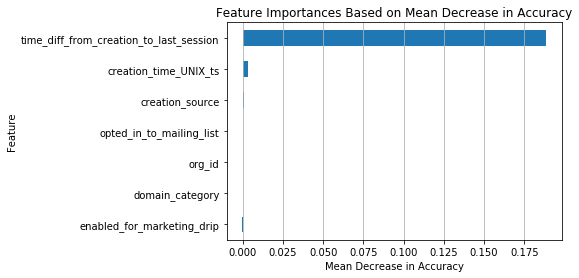

In [20]:
# plot feature importances based on mean decrease in accuracy
df_mda.sort_values(by='Mean Decrease in Accuracy').plot(kind='barh',
                                                        legend=False)

# set vertical grid lines
ax = plt.gca()
ax.xaxis.grid()

# set title and labels
plt.title('Feature Importances Based on Mean Decrease in Accuracy')
plt.ylabel('Feature')
plt.xlabel('Mean Decrease in Accuracy')